In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [94]:
def get_logistic_map(size: int, r: float = 3.99):
    series = np.zeros(size)
    series[0] = 0.5

    for i in range(1, size):
        series[i] = r * series[i - 1] * (1 - series[i - 1])

    return series

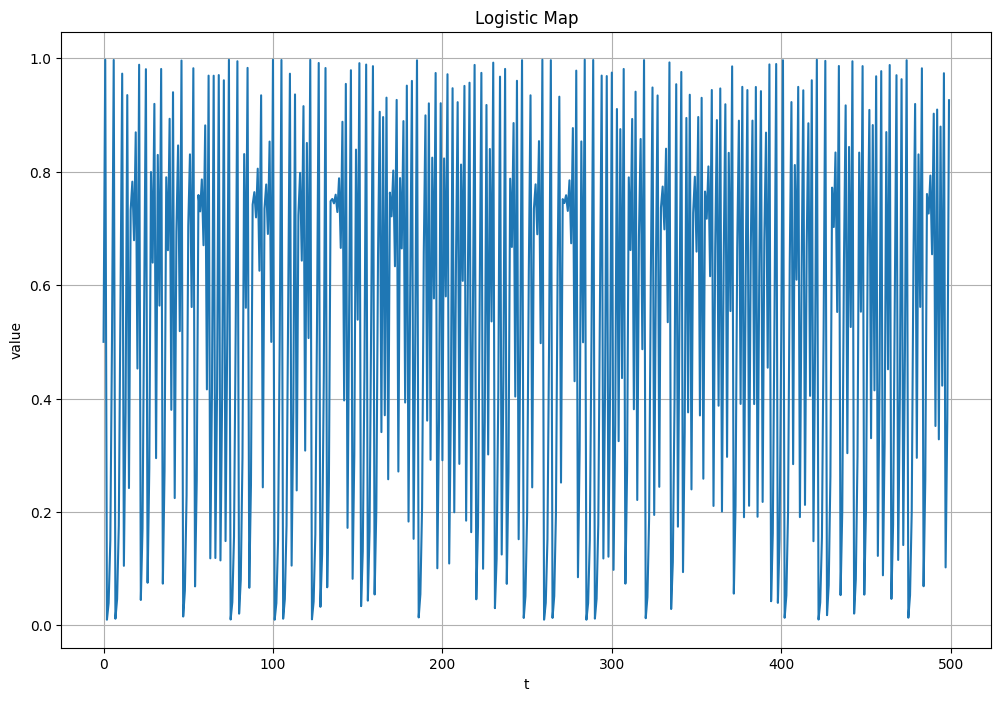

In [100]:
N = 500
series = get_logistic_map(N)

plt.figure(figsize=(12, 8))
plt.plot(series)
plt.title('Logistic Map')
plt.xlabel('t')
plt.ylabel('value')
plt.grid()
plt.show()

In [104]:
def create_nonregular_z_vectors(series: np.ndarray, taus: list[int], h: int = 1):
    zs = []
    targets = []
    max_tau = max(taus)
    for i in range(max_tau, len(series) - h):
        z = [series[i - tau] for tau in taus]
        zs.append(z)
        targets.append(series[i + h])  # Next value as target
    return np.array(zs), np.array(targets)

In [105]:
taus = [1, 4, 7, 11, 15, 31]

X, y = create_nonregular_z_vectors(series, taus)
print("Shape of z_vectors:", X.shape)
print("First 5 z-vectors:\n", X[:5])

Shape of z_vectors: (468, 6)
First 5 z-vectors:
 [[0.91963253 0.2772113  0.56468623 0.45290366 0.73214858 0.5       ]
 [0.29489506 0.79945713 0.98080461 0.98864992 0.78246708 0.9975    ]
 [0.82964854 0.63969845 0.07511945 0.04477281 0.67914728 0.00995006]
 [0.56391404 0.91963253 0.2772113  0.17064513 0.86944595 0.03930572]
 [0.98120083 0.29489506 0.79945713 0.56468623 0.45290366 0.15066553]]


In [106]:
# Split into training and test sets
train_size = int(0.8 * len(X))
X_train = X[:train_size]
y_train = y[:train_size]
X_test = X[train_size:]
y_test = y[train_size:]

In [107]:
k = 7
kmeans = KMeans(n_clusters=k, random_state=42)
kmeans.fit(X_train)
labels_train = kmeans.labels_

cluster_predictions = {}

for cluster in range(k):
    indices = np.where(labels_train == cluster)[0]
    if len(indices) == 0:
        cluster_predictions[cluster] = 0
        continue
    cluster_future_values = y_train[indices]
    cluster_predictions[cluster] = np.mean(cluster_future_values)

In [115]:
def multistep_forecast(zs, steps, kmeans, cluster_predictions):
    forecasts = []
    last_z = zs[-1].tolist()
    for _ in range(steps):
        cluster = kmeans.predict([last_z])[0]
        pred = cluster_predictions.get(cluster, 0)
        forecasts.append(pred)
        last_z = last_z[1:] + [pred]
    return forecasts

In [116]:
forecasts = multistep_forecast(X_train, len(y_test), kmeans, cluster_predictions)

In [117]:
forecasts = np.array(forecasts)
targets_test = np.array(y_test)

rmse = np.sqrt(mean_squared_error(targets_test, forecasts))
mae = mean_absolute_error(targets_test, forecasts)

print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")

RMSE: 0.3368
MAE: 0.3052


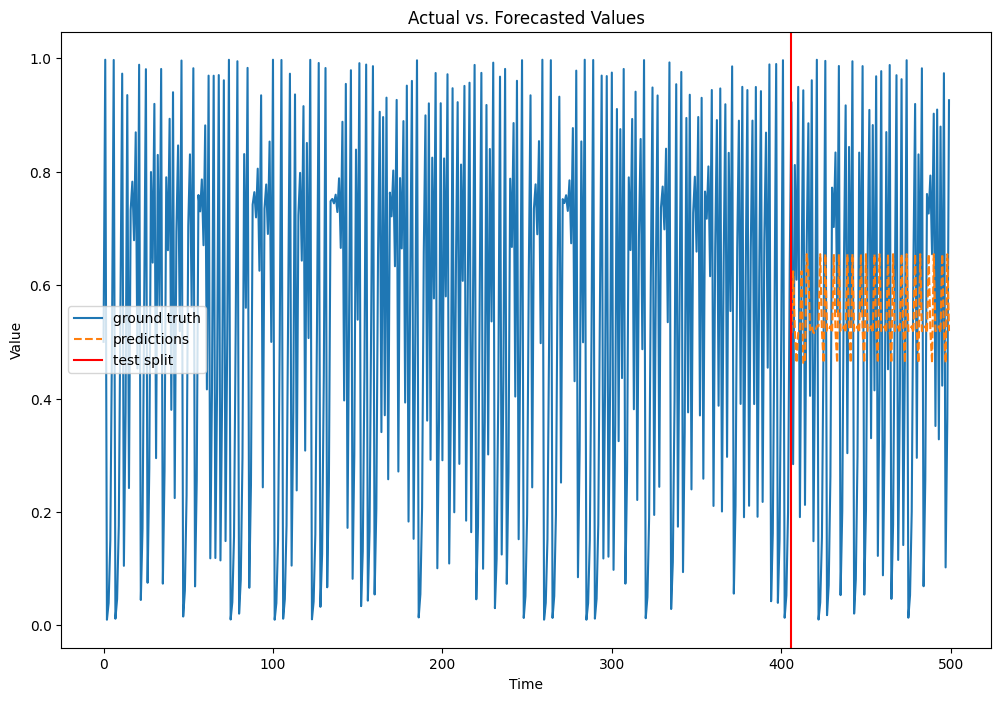

In [118]:
plt.figure(figsize=(12, 8))
plt.plot(range(len(series)), series, label='ground truth')
plt.plot(range(len(series) - len(forecasts), len(series)), forecasts, label='predictions', linestyle='--')
plt.axvline(x=len(series)-len(forecasts), color='r', linestyle='-', label='test split')
plt.legend()
plt.title('Actual vs. Forecasted Values')
plt.xlabel('Time')
plt.ylabel('Value')
plt.show()

In [144]:
def healing_forecast(zs, steps, kmeans, cluster_predictions, alpha=0.5):
    forecasts = []
    errors = []
    last_z = zs[-1].tolist()
    for i in range(steps):
        cluster = kmeans.predict([last_z])[0]
        pred = cluster_predictions.get(cluster, 0)
        if i > 0:
            pred -= alpha * errors[-1]
        forecasts.append(pred)
        last_z = last_z[1:] + [pred]
        if i < len(targets_test):
            error = targets_test[i] - pred
            errors.append(error)
        else:
            errors.append(0)
    return forecasts

In [145]:
# Forecast future values with healing algorithm
healing_forecasts = healing_forecast(X_train, len(y_test), kmeans, cluster_predictions)

# Convert forecasts and targets to numpy arrays
healing_forecasts = np.array(healing_forecasts)

# Compute error metrics
rmse_healing = np.sqrt(mean_squared_error(targets_test, healing_forecasts))
mae_healing = mean_absolute_error(targets_test, healing_forecasts)

print(f"RMSE with Healing: {rmse_healing:.4f}")
print(f"MAE with Healing: {mae_healing:.4f}")

RMSE with Healing: 0.3460
MAE with Healing: 0.2963


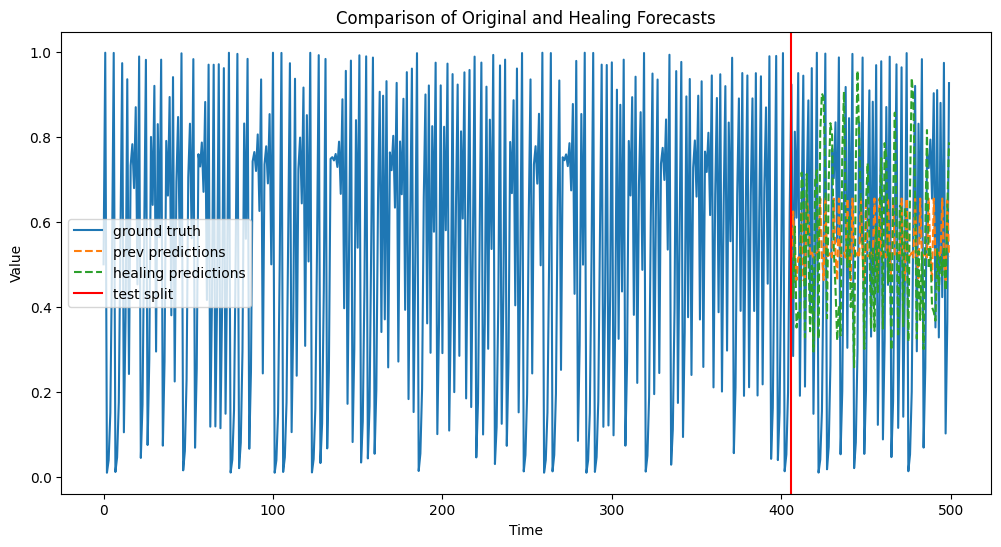

In [147]:
plt.figure(figsize=(12,6))
plt.plot(range(len(series)), series, label='ground truth')
plt.plot(range(len(series) - len(forecasts), len(series)), forecasts, label='prev predictions', linestyle='--')
plt.plot(range(len(series) - len(healing_forecasts), len(series)), healing_forecasts, label='healing predictions', linestyle='--')
plt.axvline(x=len(series) - len(forecasts), color='r', linestyle='-', label='test split')
plt.legend()
plt.title('Comparison of Original and Healing Forecasts')
plt.xlabel('Time')
plt.ylabel('Value')
plt.show()